## Project Setup

In [1]:
import os
import re
import bs4
import matplotlib.pyplot as plt
import pytest
import pandas as pd
from pandas import read_parquet
import requests
import sqlalchemy as db
import geopandas
import numpy as np
import warnings
import folium
from folium.plugins import HeatMap
warnings.filterwarnings("ignore")

In [2]:
# global variables

TAXI_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"
UBER_CSV = "uber_rides_sample.csv"
SHP_FILE = 'taxi_zones.shp'
NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))

DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"

## Part 1: Data Preprocessing

For part 1, we mainly need to process the data according to the following steps:
1. Define a function that can calculate the distance between two locations.
2. Download and clean the yellow taxi data from the NYC Taxi & Limousine Commission
3. Load and clean uber data
4. Load and clean weather

Note: The time range of yellow taxi, uber and weather is: 2009-01 to 2015-06.

### Calculating distance
Calculate the distance bewteen two locations by Haversine Formula

In [3]:
def calculate_distance(lon1, lat1, lon2, lat2):
    """
      Calculate the distance between two locations by their longitude and latitude in kilometers by Haversine formula. 

      Parameter Explanation in this function:
      lon1 ----- longitude of pickup location
      lat1 ----- latitude of pickup location
      lon2 ----- longitude of dropoff location
      lat2 ----- latitude of dropoff location  
    """
    #Convert latitude and longitude to radius
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    newlon = lon2 - lon1
    newlat = lat2 - lat1
    # Calculate the distance
    haver_formula = np.sin(newlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(newlon/2.0)**2

    dist = 2 * np.arcsin(np.sqrt(haver_formula ))
    #6367 for distance in KM for miles use 3958
    km = 6367 * dist 
    return km
    
    

In [4]:
def add_distance_column(dataframe):
    """
    Add the series of value calculated by the calculate_distance function to the dataframe column

    Parameter Explanation:
    dataframe ---- a dataframe needs to add distance column

    """
    dataframe['distance']=calculate_distance(dataframe['pickup_longitude'],dataframe['pickup_latitude'],dataframe['dropoff_longitude'],dataframe['dropoff_latitude'])
    return dataframe

### Processing Taxi Data

Get the urls to download the data.

In [5]:
def get_taxi_html():
    response = requests.get(TAXI_URL)
    html = response.content
    return html

def find_taxi_csv_urls():
    # After getting the html, we are going to analyze the html and get the information we want, which is the url linked to "Yellow Taxi Trip Records"
    html = get_taxi_html()
    soup = bs4.BeautifulSoup(html, "html.parser")
    links = soup.find_all("a", href=True)

    urls = []
    for link in links:
        # use regular expression to find the links that match the pattern 2009-01~2015-06
        if re.search(r"yellow_tripdata_2009|yellow_tripdata_201[0-4]|yellow_tripdata_2015-0[1-6]", link.get("href")):
            urls.append(link.get("href"))
    return urls

Clean the yellow taxi data

In [6]:
def get_and_clean_month_taxi_data(url):
    # the input 'url' is one of the urls we get through function 'find_taxi_csv_urls()'
    # input: a dataframe; the url where we can download one month' taxi trip record
    # todo: download; clean data
    # output: a dataframe; processed trip records for one month
    
    
    # download and read trip record data
    file_name = url.split('/')[-1]
    # download the file if it doesn't exist
    if not os.path.exists(file_name):
        print("downloading", file_name)
        file = requests.get(url)
        with open(file_name , "wb") as f:
            f.write(file.content)
    trip_data = pd.read_parquet(file_name)
    print("cleaning", file_name)
    

    # scale down sample volume to match the volume of uber data
    # samples from each month = volume of uber data / numbers of monthly taxi data packs = 2*10^5 / (6.5*12) = 2564
    trip_data = trip_data.sample(n=2564)
    
    
    # from location ID to longtitude and latitude
    def ID_to_LonLat(df):
        # import shp files, containing location ID info
        
        sf_path = r'taxi_zones.shp'
        taxi_zone = geopandas.GeoDataFrame.from_file(sf_path)
        # we translate the location ID into lontitude and latitude
        taxi_zone = taxi_zone.to_crs(4326)
        taxi_zone['lon'] = taxi_zone.centroid.x  
        taxi_zone['lat'] = taxi_zone.centroid.y
        # to save time in the upcoming merging process, we remove unnecessary columns first
        taxi_zone = taxi_zone[['LocationID','lon','lat']]
        taxi_zone.drop_duplicates('LocationID',inplace=True)
        taxi_zone.set_index('LocationID',inplace=True)
        
        # we apply the relation between location ID and longtitude and latitude to our real world dataframe
        df['pickup_latitude'] = df['PULocationID'].map(taxi_zone['lat'])
        df['pickup_longitude'] = df['PULocationID'].map(taxi_zone['lon'])
        df['dropoff_latitude'] = df['DOLocationID'].map(taxi_zone['lat'])
        df['dropoff_longitude'] = df['DOLocationID'].map(taxi_zone['lon'])
        return df
    
    # not every dataset contains location ID, which needs to be interpreted. 
    # so we run a function to judge if a translation is needed
    if 'PULocationID' in trip_data.columns:
        trip_data = ID_to_LonLat(trip_data)
    
 
    
    # normalizing column;
    # rename columns
    columns_rename = {
        'tpep_pickup_datetime':'pickup_datetime',
        'Trip_Pickup_DateTime':'pickup_datetime',
        'Start_Lon':'pickup_longitude',
        'lon_pickup':'pickup_longitude',
        'Start_Lat':'pickup_latitude',
        'lat_pickup':'pickup_latitude',
        'lon_dropoff':'dropoff_longitude',
        'End_Lon':'dropoff_longitude',
        'lat_dropoff':'dropoff_latitude',
        'End_Lat':'dropoff_latitude',
        'Tip_Amt':'tip_amount'
    }
    trip_data = trip_data.rename(columns=columns_rename)
    
    # only keep date, time and geographic information, which we will use later (second time filtering)
    trip_data = trip_data[['pickup_datetime','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','tip_amount']]
    
    
    # select valid data; 
    trip_data = trip_data[(trip_data['pickup_latitude'] >= NEW_YORK_BOX_COORDS[0][0]) & (trip_data['pickup_latitude'] <= NEW_YORK_BOX_COORDS[1][0])]
    trip_data = trip_data[(trip_data['pickup_longitude'] >= NEW_YORK_BOX_COORDS[0][1]) & (trip_data['pickup_longitude'] <= NEW_YORK_BOX_COORDS[1][1])]
    trip_data = trip_data[(trip_data['dropoff_latitude'] >= NEW_YORK_BOX_COORDS[0][0]) & (trip_data['dropoff_latitude'] <= NEW_YORK_BOX_COORDS[1][0])]
    trip_data = trip_data[(trip_data['dropoff_longitude'] >= NEW_YORK_BOX_COORDS[0][1]) & (trip_data['dropoff_longitude'] <= NEW_YORK_BOX_COORDS[1][1])] 
    
    # Separate the date and the specific time, then create a distinct column
    trip_data ['pickup_datetime'] = trip_data['pickup_datetime'].map(lambda x: str(x)[:-3])
    trip_data ['pickup_datetime']= pd.to_datetime(trip_data['pickup_datetime'], format="%Y-%m-%d %H:%M:%S") 
    trip_data ['Date']= trip_data['pickup_datetime'].dt.date
    trip_data ['Hour'] = trip_data['pickup_datetime'].dt.hour
    trip_data = trip_data.drop('pickup_datetime',axis=1)

    # Defining the data type of each column in the dataframe
    trip_data['Date'] = pd.to_datetime(trip_data['Date'])
    trip_data = trip_data.astype({'pickup_longitude':'float','pickup_latitude':'float','dropoff_longitude':'float','dropoff_latitude':'float','tip_amount':'float'})
    
    
    return trip_data

In [7]:
def get_and_clean_taxi_data():
    """
    Add distance column to each yellow taxi dataframe

    The function will return a dataframe
    """

    all_taxi_dataframes = []
    # process all the url
    all_csv_urls = find_taxi_csv_urls()
    # add the distance column to every dataframe
    for csv_url in all_csv_urls:

        dataframe = get_and_clean_month_taxi_data(csv_url)
        add_distance_column(dataframe)

        
        all_taxi_dataframes.append(dataframe)
    # concatenate every dataframe
    taxi_data = pd.concat(all_taxi_dataframes)
    return taxi_data

### Processing Uber Data

For this part, we will load and clean the uber data. We need to make sure the data type and size of uber consistent with yellow taxi.

In [8]:
def load_and_clean_uber_data(csv_file):
    """
    load the uber data and clean uber data

    Parameter Explanation:
    csv_file ---- the file we need to process

    The function will return a dataframe
    """

    # Import the data
    data = pd.read_csv(csv_file)
    print("cleaning", csv_file)
    # Select valid data
    data = data[(data['pickup_latitude'] >= NEW_YORK_BOX_COORDS[0][0]) & (data['pickup_latitude'] <= NEW_YORK_BOX_COORDS[1][0])]
    data = data[(data['pickup_longitude'] >= NEW_YORK_BOX_COORDS[0][1]) & (data['pickup_longitude'] <= NEW_YORK_BOX_COORDS[1][1])]
    data = data[(data['dropoff_latitude'] >= NEW_YORK_BOX_COORDS[0][0]) & (data['dropoff_latitude'] <= NEW_YORK_BOX_COORDS[1][0])]
    data = data[(data['dropoff_longitude'] >= NEW_YORK_BOX_COORDS[0][1]) & (data['dropoff_longitude'] <= NEW_YORK_BOX_COORDS[1][1])]    
    UBER_DATA = data[['pickup_datetime','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']]

    # Separate the date and the specific time, then create a distinct column
    UBER_DATA ['pickup_datetime'] = UBER_DATA['pickup_datetime'].map(lambda x: str(x)[:-3])
    UBER_DATA ['pickup_datetime']= pd.to_datetime(UBER_DATA['pickup_datetime'], format="%Y-%m-%d %H:%M:%S") 
    UBER_DATA ['Date']= UBER_DATA['pickup_datetime'].dt.date
    UBER_DATA ['Hour'] = UBER_DATA['pickup_datetime'].dt.hour
    UBER_DATA = UBER_DATA.drop('pickup_datetime',axis=1)

    # Defining the data type of each column in the dataframe
    UBER_DATA['Date'] = pd.to_datetime(UBER_DATA['Date'])
    UBER_DATA = UBER_DATA.astype({'pickup_longitude':'float','pickup_latitude':'float','dropoff_longitude':'float','dropoff_latitude':'float'})
    return UBER_DATA

In [9]:
def get_uber_data():
    """
    Add distance column to uber dataframe

    The function will return a dataframe
    """
    uber_dataframe = load_and_clean_uber_data(UBER_CSV)
    add_distance_column(uber_dataframe)
    uber_dataframe = uber_dataframe.astype({'distance':'float'})
    return uber_dataframe

### Processing Weather Data

For this part, we will load and clean the weather data in hourly and daily

In [10]:
def clean_month_weather_data_hourly(csv_file):
    """
    load the uber data and clean of each year of weather data in hourly

    Parameter Explanation:
    csv_file ---- the file we need to process

    The function will return a dataframe
    """
  

    # Import the data and select valid data
    df = pd.read_csv(csv_file)
    weather_hourly_data=df[["DATE","HourlyPrecipitation","HourlyWindSpeed"]]
    # Remove missing values
    weather_hourly_data['HourlyPrecipitation'] = pd.to_numeric(weather_hourly_data['HourlyPrecipitation'], errors='coerce')
    # Calculate average speed in hourly
    wind_speed_average = int(weather_hourly_data['HourlyWindSpeed'].mean())

    # fill out the missing values
    weather_hourly_data['HourlyPrecipitation'].fillna(0, inplace=True)
    weather_hourly_data['HourlyWindSpeed'].fillna(wind_speed_average, inplace=True)

    # Separate the date and the specific time, then create a distinct column
    weather_hourly_data ['DATE']= pd.to_datetime(weather_hourly_data['DATE'], format="%Y-%m-%d %H:%M:%S") 
    weather_hourly_data ['Date']= weather_hourly_data['DATE'].dt.date
    weather_hourly_data ['time']  = weather_hourly_data['DATE'].dt.hour
    weather_hourly_data = weather_hourly_data.drop('DATE',axis=1)

    # Defining the data type of each column in the dataframe
    weather_hourly_data['Date'] = pd.to_datetime(weather_hourly_data['Date'])
    weather_hourly_data = weather_hourly_data.astype({'HourlyPrecipitation':'float','HourlyWindSpeed':'int'})  
    
    return weather_hourly_data

In [11]:
def clean_month_weather_data_daily(csv_file):
    """
    load the uber data and clean of each year of weather data in hourly and get the sunrise and sunset data.

    Parameter Explanation:
    csv_file ---- the file we need to process

    The function will return two dataframes ---- weather daily and daily sunset/sunrise
    """

    # Import the data
    weather_daily_data = pd.read_csv(csv_file)
    weather_daily_data['DATE'] = pd.to_datetime(weather_daily_data['DATE'])
    
    #Remove missing values and fill out the missing values
    weather_daily_data['HourlyPrecipitation'] = pd.to_numeric(weather_daily_data['HourlyPrecipitation'], errors='coerce')
    weather_daily_data['HourlyPrecipitation'].fillna(0, inplace=True)

    #calculate the average windspeed and sum of the precipitation
    weather_daily_data['DATE'] = weather_daily_data['DATE'].dt.date
    weather_daily_data_1 = weather_daily_data.groupby('DATE', as_index=False).agg({'HourlyWindSpeed': np.mean, 'HourlyPrecipitation': np.sum})
    weather_daily_data_1 = weather_daily_data_1[['DATE','HourlyWindSpeed','HourlyPrecipitation']]
    # Defining the data type of each column in the dataframe
    weather_daily_data_1['DATE'] = pd.to_datetime(weather_daily_data_1['DATE'])
    weather_daily_data_1.rename(columns={'DATE':'Date','HourlyWindSpeed': 'DailyWindSpeed', 'HourlyPrecipitation': 'DailyPrecipitation'}, inplace=True)
    weather_daily_data_1 = weather_daily_data_1.astype({'DailyWindSpeed':'float', 'DailyPrecipitation':'float'})
    
    #Get the data of sunrise and sunset
    weather_daily_data_sun= weather_daily_data.groupby('DATE', as_index=False).agg({'Sunrise': 'first', 'Sunset': 'first'})
    weather_daily_data_sun = weather_daily_data[['DATE','Sunrise','Sunset']]
    weather_daily_data_sun = weather_daily_data_sun.dropna()
    
    # Defining the data type of each column in the dataframe
    weather_daily_data_sun.rename(columns={'DATE':'Date'}, inplace=True)
    weather_daily_data_sun['Date'] = pd.to_datetime(weather_daily_data_sun['Date'])
    weather_daily_data_sun = weather_daily_data_sun.astype({'Sunrise': 'int', 'Sunset': 'int'})
    
    
    return weather_daily_data_1, weather_daily_data_sun

In [12]:
def load_and_clean_weather_data():
    """
    Process all the weather data we need. 

    The function will return a dataframe
    """
    hourly_dataframes = []
    daily_dataframes = []
    sun_dataframes = []
    
    # all the name of the weather files
    weather_csv_files = ["2009_weather.csv", "2010_weather.csv", "2011_weather.csv", "2012_weather.csv", "2013_weather.csv", "2014_weather.csv", "2015_weather.csv"]
    
    for csv_file in weather_csv_files:
        print("cleaning", csv_file)
        hourly_dataframe = clean_month_weather_data_hourly(csv_file)
        daily_dataframe = clean_month_weather_data_daily(csv_file)[0]
        daily_sun_dataframe = clean_month_weather_data_daily(csv_file)[1]
        hourly_dataframes.append(hourly_dataframe)
        daily_dataframes.append(daily_dataframe)
        sun_dataframes.append(daily_sun_dataframe)
        
        
    # create two dataframes with hourly & daily data from every month
    hourly_data = pd.concat(hourly_dataframes)
    daily_data = pd.concat(daily_dataframes)
    sun_data = pd.concat(sun_dataframes)
    
    return hourly_data, daily_data, sun_data

### Process All Data

Now, we can get all the data we want.

In [15]:
taxi_data = get_and_clean_taxi_data()
uber_data = get_uber_data()
hourly_weather_data, daily_weather_data, sun_data = load_and_clean_weather_data()

cleaning yellow_tripdata_2015-01.parquet
cleaning yellow_tripdata_2015-02.parquet
cleaning yellow_tripdata_2015-03.parquet
cleaning yellow_tripdata_2015-04.parquet
cleaning yellow_tripdata_2015-05.parquet
cleaning yellow_tripdata_2015-06.parquet
cleaning yellow_tripdata_2014-01.parquet
cleaning yellow_tripdata_2014-02.parquet
cleaning yellow_tripdata_2014-03.parquet
cleaning yellow_tripdata_2014-04.parquet
cleaning yellow_tripdata_2014-05.parquet
cleaning yellow_tripdata_2014-06.parquet
cleaning yellow_tripdata_2014-07.parquet
cleaning yellow_tripdata_2014-08.parquet
cleaning yellow_tripdata_2014-09.parquet
cleaning yellow_tripdata_2014-10.parquet
cleaning yellow_tripdata_2014-11.parquet
cleaning yellow_tripdata_2014-12.parquet
cleaning yellow_tripdata_2013-01.parquet
cleaning yellow_tripdata_2013-02.parquet
cleaning yellow_tripdata_2013-03.parquet
cleaning yellow_tripdata_2013-04.parquet
cleaning yellow_tripdata_2013-05.parquet
cleaning yellow_tripdata_2013-06.parquet
cleaning yellow_

In [21]:
### Begin unit test, to ensure we have the right columns and the column of 'distance' added
def test_add_col(df):
    # expected column names
    columns = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'tip_amount', 'Date', 'Hour', 'distance']
    # ensure every required name, including 'distance' is in the dataframe
    for column in columns:
        assert column in df.columns
    
## Begin test  
test_add_col(taxi_data)

## Part 2: Storing Cleaned Data

We need to create a database for storing cleaned data by SQL and sqlalchemy. We mainly will do the following steps:


1.   Build the table for each dataframe.
2.   Create schema.sql file 
3.   Save all the table in the schema.sql file
4.   Add all the data into the database




In [22]:
engine = db.create_engine(DATABASE_URL)

In [23]:
HOURLY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS hourly_weather_schema
(
  Date DATE,
  time TIME,
  HourlyPrecipitation INTEGER,
  HourlyWindGustSpeed INTEGER,
  id INTEGER PRIMARY KEY
)
"""

DAILY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS daily_weather_schema
(
  Date DATE,
  DailyPrecipitation INTEGER,
  DailyAverageWindSpeed INTEGER,
  id INTEGER PRIMARY KEY
)
"""

TAXI_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS taxi_trips    
(
  Date DATE,
  Hour TIME,
  pickup_longitude FLOAT,
  pickup_latitude FLOAT,
  dropoff_longitude FLOAT,
  dropoff_latitude FLOAT,
  distance FLOAT,
  tip_amount FLOAT,
  id INTEGER PRIMARY KEY
)
"""


UBER_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS daily_weather_schema
(
  Date DATE,
  Hour TIME,
  pickup_longitude FLOAT,
  pickup_latitude FLOAT,
  dropoff_longitude FLOAT,
  dropoff_latitude FLOAT,
  distance FLOAT,
  id INTEGER PRIMARY KEY
)
"""

SUN_DATA_SCHEMA = """
CREATE TABLE IF NOT EXISTS sun_data 
(
    Date DATE,
    Sunrise INT,
    Sunset INT,
    id INTEGER PRIMARY KEY AUTOINCREMENT
)
"""

In [24]:
# create that required schema.sql file
with open(DATABASE_SCHEMA_FILE, "w") as f:
    f.write(HOURLY_WEATHER_SCHEMA)
    f.write(DAILY_WEATHER_SCHEMA)
    f.write(TAXI_TRIPS_SCHEMA)
    f.write(UBER_TRIPS_SCHEMA)
    f.write(SUN_DATA_SCHEMA)

In [25]:
# create the tables with the schema files

with engine.connect() as connection:
    with open(DATABASE_SCHEMA_FILE, "r") as f:
        rows = f.readlines()
        extra_space = []
        for line in rows:
            extra_space.append(line)
            # if the line is a ')', execute the query
            if ")" in line:
                connection.execute(db.text("".join(extra_space)))
                extra_space = []

### Add Data to Database

Add all the cleaned data into the Database

In [30]:
def write_dataframes_to_table(table_to_df_dict):
    for table, dataframe in table_to_df_dict.items():
        print("writing", table)
        dataframe.to_sql(table, con=engine, if_exists='replace', index=False)

In [31]:
map_table_name_to_dataframe = {
    "taxi_trips": taxi_data,
    "uber_trips": uber_data,
    "hourly_weather": hourly_weather_data,
    "daily_weather": daily_weather_data,
    "sun_data": sun_data
}

In [32]:
write_dataframes_to_table(map_table_name_to_dataframe)

writing taxi_trips
writing uber_trips
writing hourly_weather
writing daily_weather
writing sun_data


## Part 3: Understanding the Data

We will be crafting a set of SQL queries.

In [33]:
def write_query_to_file(query, outfile):
    with open(outfile, "w") as f:
        f.write(query) 

### Query 1

For 01-2009 through 06-2015, the most popular hour of the day to take a yellow taxi.

In [34]:
QUERY_1 = """
Select Hour As hours, Count(*) As amount
From taxi_trips
Group By hours
Order By amount DESC;
"""

In [35]:
engine.execute(QUERY_1).fetchall()

[(19, 12171),
 (18, 11669),
 (20, 11476),
 (21, 11122),
 (22, 10763),
 (14, 9896),
 (17, 9633),
 (23, 9596),
 (12, 9592),
 (13, 9575),
 (15, 9411),
 (9, 9194),
 (11, 9172),
 (8, 8830),
 (10, 8724),
 (16, 8109),
 (0, 7760),
 (7, 7135),
 (1, 5776),
 (2, 4252),
 (6, 3990),
 (3, 3117),
 (4, 2251),
 (5, 1940)]

In [36]:
write_query_to_file(QUERY_1, "most_popular_hour.sql")

### Query 2

Find the most popular day of the week to take a uber

In [37]:
QUERY_2 = """
Select strftime('%w', Date) As weekday, Count(*) As amount
From uber_trips
Group By weekday
Order By amount DESC;
"""

In [38]:
engine.execute(QUERY_2).fetchall()

[('5', 30166),
 ('6', 29599),
 ('4', 29338),
 ('3', 28328),
 ('2', 27526),
 ('0', 25834),
 ('1', 24681)]

In [39]:
write_query_to_file(QUERY_2, "most_popular_day.sql")

### Query 3

Find the 95% percentile of distance traveled for all hired trips during July 2013.

In [40]:
QUERY_3 = """
WITH hired_trips AS
(
SELECT Date, distance FROM taxi_trips WHERE Date BETWEEN '2013-07-01' AND '2013-08-01'
UNION ALL
SELECT Date, distance FROM uber_trips WHERE Date BETWEEN '2013-07-01' AND '2013-08-01'
)

SELECT distance AS '95%_percentile_of_distance'
FROM hired_trips
ORDER BY distance ASC
LIMIT 1
OFFSET (SELECT COUNT(*) FROM hired_trips) * 95 / 100 - 1;
"""

In [41]:
engine.execute(QUERY_3).fetchall()

[(9.873228885397031,)]

In [42]:
write_query_to_file(QUERY_3, "95%_percentile_of_distance_201307.sql")

### Query 4

Find the top 10 days with the highest number of hired rides for 2009, and the average distance for each day

In [43]:
QUERY_4 = """
WITH hired_trips AS
(
SELECT Date, distance FROM taxi_trips WHERE Date BETWEEN '2009-01-01' AND '2009-12-31'
UNION ALL
SELECT Date, distance FROM uber_trips WHERE Date BETWEEN '2009-01-01' AND '2009-12-31'
)


SELECT DATE(Date), COUNT(*) AS 'number_of_hired_rides', distance / COUNT(*) AS 'daily_average_distance'
FROM hired_trips 
GROUP BY DATE(Date)
ORDER BY number_of_hired_rides DESC
LIMIT 10;
"""

In [44]:
engine.execute(QUERY_4).fetchall()

[('2009-12-11', 231, 0.013244210952265122),
 ('2009-04-04', 218, 0.011149921256261899),
 ('2009-05-08', 215, 0.0032584092248406356),
 ('2009-10-23', 212, 0.006924074380601734),
 ('2009-06-05', 212, 0.023072842538076257),
 ('2009-04-18', 208, 0.02092641783492267),
 ('2009-03-20', 208, 0.0011323278047152326),
 ('2009-07-08', 207, 0.008298525864599109),
 ('2009-04-03', 207, 0.0011391592322214596),
 ('2009-02-28', 206, 0.022730438567422274)]

### Query 5

Find the number of hired trips on the top 10 windiest days in 2014

In [45]:
QUERY_5 = """
WITH hired_trips(date) AS
(
SELECT DATE(Date) FROM taxi_trips WHERE Date BETWEEN '2014-01-01' AND '2014-12-31'
UNION ALL
SELECT DATE(Date) FROM uber_trips WHERE Date BETWEEN '2014-01-01' AND '2014-12-31'
)

SELECT date , COUNT(*) AS 'trips' FROM hired_trips
GROUP BY date
HAVING date IN 
(
SELECT DATE(Date) 
FROM daily_weather 
WHERE DATE(Date) BETWEEN '2014-01-01' AND '2014-12-31' 
ORDER BY DailyWindSpeed DESC 
LIMIT 10
)
"""

In [46]:
engine.execute(QUERY_5).fetchall()

[('2014-01-02', 125),
 ('2014-01-07', 180),
 ('2014-02-13', 132),
 ('2014-03-13', 200),
 ('2014-03-26', 171),
 ('2014-03-29', 200),
 ('2014-11-02', 158),
 ('2014-12-07', 165),
 ('2014-12-08', 162),
 ('2014-12-09', 172)]

In [47]:
write_query_to_file(QUERY_5, "10_windiest_days_in_2014.sql")

### Query 6

Find out how many trips were taken each hour, and for each hour, how much precipitation did NYC receive and what the sustained wind speed was during Hurricane Sandy in NYC (Oct 29-30, 2012), plus the week leading up and the week after.

In [48]:
QUERY_6 = """
WITH hired_trips(date) AS
(
SELECT DATE(Date) FROM taxi_trips WHERE Date BETWEEN '2012-10-22' AND '2012-11-06'
UNION ALL
SELECT DATE(Date) FROM uber_trips WHERE Date BETWEEN '2012-10-22' AND '2012-11-06'
)

SELECT Date(hourly_weather.Date) AS weather_date, COUNT(hired_trips.DATE) AS 'number_of_days', HourlyPrecipitation, HourlyWindSpeed
FROM hourly_weather
LEFT JOIN hired_trips
ON weather_date = hired_trips.date
WHERE weather_date BETWEEN '2012-10-22' AND '2012-11-06'
GROUP BY weather_date;
"""

In [49]:
engine.execute(QUERY_6).fetchall()

[('2012-10-22', 3575, 0.0, 7),
 ('2012-10-23', 4320, 0.0, 3),
 ('2012-10-24', 6591, 0.0, 3),
 ('2012-10-25', 5670, 0.0, 6),
 ('2012-10-26', 4428, 0.0, 0),
 ('2012-10-27', 6528, 0.0, 3),
 ('2012-10-28', 4030, 0.0, 11),
 ('2012-10-29', 2544, 0.0, 16),
 ('2012-10-30', 3024, 0.03, 13),
 ('2012-10-31', 3298, 0.0, 3),
 ('2012-11-01', 3150, 0.0, 3),
 ('2012-11-02', 2975, 0.0, 5),
 ('2012-11-03', 4550, 0.0, 7),
 ('2012-11-04', 3900, 0.0, 9),
 ('2012-11-05', 3900, 0.0, 0),
 ('2012-11-06', 0, 0.0, 6)]

In [50]:
write_query_to_file(QUERY_6, "hurricane_trips.sql")

## Part 4: Visualizing the Data

Creating visualizations to enhance the understanding of the datasets

### **Visualization 1**

Create an appropriate visualization for the most popular hour of the day to take a yellow taxi.


In [51]:
def hour_for_taxi_trip(dataframe):
    # The format of the diagram 
    dataframe.plot(x="hours", y="amount",kind="bar",figsize=(10, 10))
    plt.xlabel('Hour')
    plt.ylabel('Number of Trips')
    plt.title('Num of Taxi Trips per Hour')
    plt.show()

In [52]:
def get_data_for_visual_1():
    # select the data  
    df = pd.read_sql_query(QUERY_1, engine)
    return df

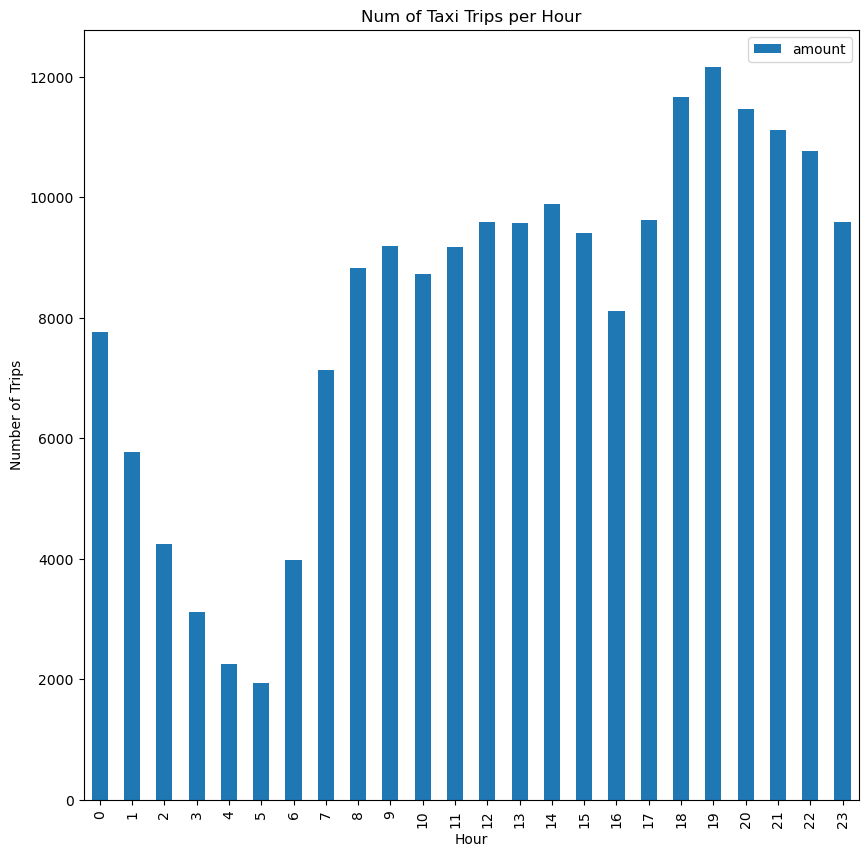

In [53]:
some_dataframe = get_data_for_visual_1()
hour_for_taxi_trip(some_dataframe.sort_values(by="hours",ascending=True))

### **Visualization 2**

Plot an histogram to show the average the average distance traveled per month


In [54]:
def average_distance_traveled(dataframe):
    # The format of the diagram 
    dataframe.plot(x="month", y="average",kind="bar",figsize=(10, 10))
    plt.xlabel('Month')
    plt.ylabel('Average distance')
    plt.title('Average Distance Traveled Per Month')
    plt.show()

In [55]:
def get_data_for_visual_2():

    # select the data  
    query_average_distance = '''
    WITH hired_trips AS 
    (
    SELECT Date,distance FROM taxi_trips 
    UNION ALL
    SELECT Date,distance FROM uber_trips
    )

    SELECT strftime('%m', Date) as month, AVG(average_month_distance) as average
    From (SELECT Date, SUM(distance) AS average_month_distance FROM hired_trips 
    group by strftime('%Y-%m', Date))
    Group by month;
    '''
    df = pd.read_sql_query(query_average_distance, engine)
    return df

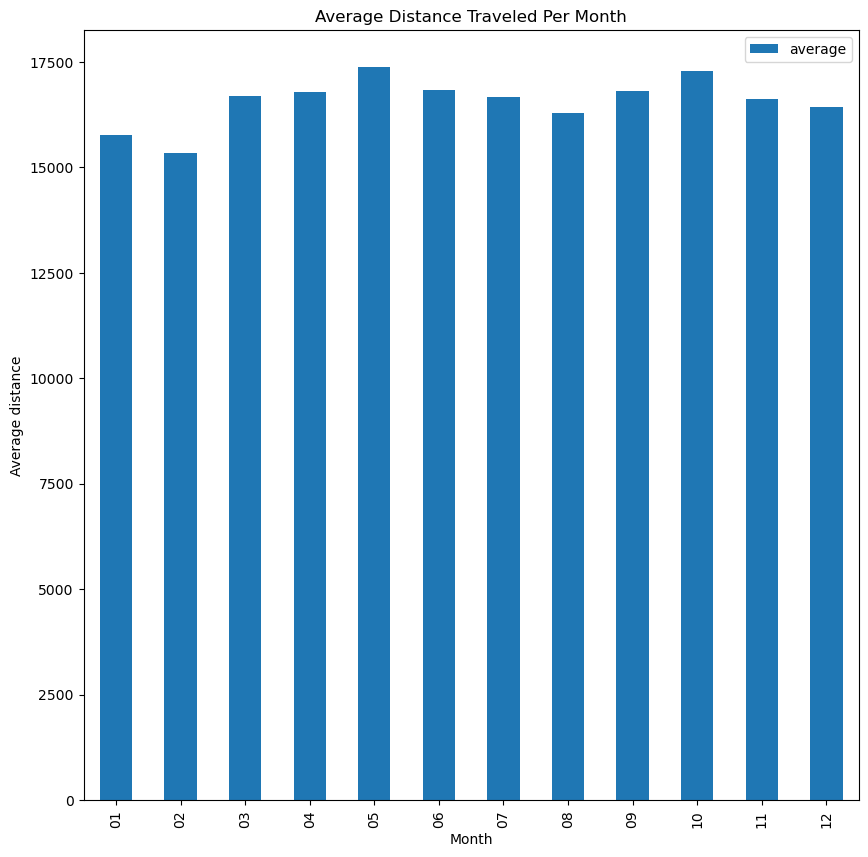

In [56]:
some_dataframe = get_data_for_visual_2()
average_distance_traveled(some_dataframe.sort_values(by="month", ascending=True))

### **Visualization 3**

Plot a diagram show the most popular for drop offs for each airport (LGA, JFK, and EWR) day of the week. 

In [57]:
def dropoff_num_for_each_day(df):
    df[0]['JFK'] = df[1]['JFK']
    df[0]['EWR'] = df[2]['EWR']
    plot = df[0].plot( x="day", y=["LGA",'JFK','EWR'], xlabel="Days", ylabel="Number of Dropoffs", kind="bar", title="Number of Dropoffs of Each Day for each Airport")
    plot.set_xticklabels(('Sunday','Monday','Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'))

In [58]:
def get_data_for_visual_3():
    # select the data 
    JFK_BBOX = [-73.826754,40.638476,-73.733714,40.667128,'JFK']
    EWR_BBOX = [-74.200917,40.663963,-74.146328,40.709262,'EWR']
    LGA_BBOX = [-73.891110,40.763483,-73.857121,40.785583,'LGA']
    
    
    df = []
    for BBOX in [LGA_BBOX, JFK_BBOX, EWR_BBOX]:
        query = f'''
        WITH hired_trips AS 
        (
        SELECT Date, dropoff_longitude, dropoff_latitude FROM taxi_trips
        UNION ALL
        SELECT Date, dropoff_longitude,dropoff_latitude FROM uber_trips
        )
        
        SELECT strftime('%w', Date) AS day, COUNT(*) AS {BBOX[4]}
        FROM hired_trips
        WHERE dropoff_longitude BETWEEN {BBOX[0]} AND {BBOX[2]} AND dropoff_latitude BETWEEN {BBOX[1]} AND {BBOX[3]}
        GROUP BY day
        '''
        df.append(pd.read_sql_query(query, engine))
        
    return df

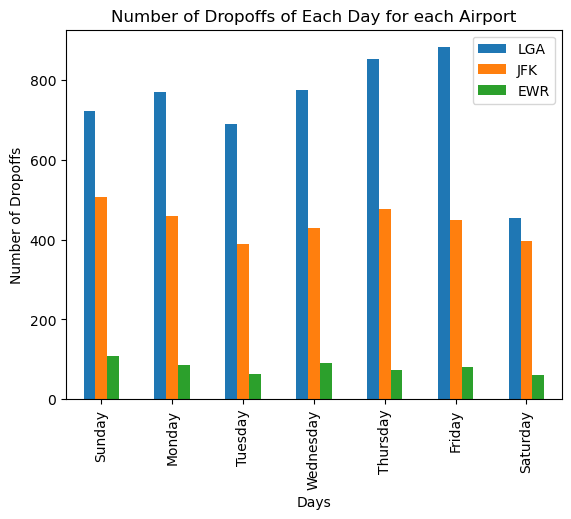

In [59]:
airport_dataframe = get_data_for_visual_3()
dropoff_num_for_each_day(airport_dataframe)

### **Visualization 4**

Plot a scatter to show the relatonship between tip amount and distance. 

In [60]:
def tip_amount(dataframe):
    # The format of the diagram 
    dataframe.plot(x="distance", y="tip_amount",kind="scatter",figsize=(10, 10))
    plt.xlabel('Distance')
    plt.ylabel('Tip')
    plt.title('Distance VS Tip')

In [61]:
def get_data_for_visual_5():
    
    # select the data    
    query_tip = '''
    SELECT tip_amount, distance FROM taxi_trips
    '''
    df = pd.read_sql_query(query_tip, engine)
    return df

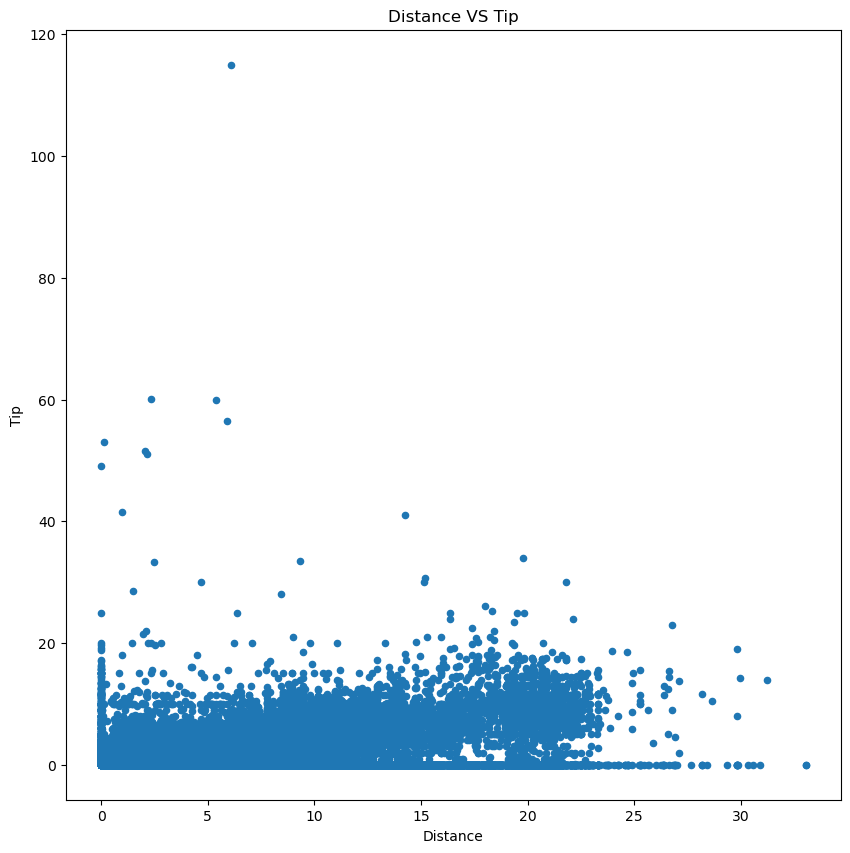

In [62]:
some_dataframe = get_data_for_visual_5()
tip_amount(some_dataframe)

### **Visualization 5**

Plot a scatter to show the relatonship between tip amount and precipitation. 

In [63]:
def tip_vs_precipitation(dataframe):
    # The format of the diagram 
    dataframe.plot(x="precipitation", y="tip", kind="scatter",figsize=(10, 10) )
    plt.xlabel('Precipitation')
    plt.ylabel('Tip Amount')
    plt.title('Tip Amount vs Precipitation')

In [64]:
def get_data_for_visual_6():
    
    # select the data
    query_precipitation = '''
    Select tips.DATE, tips.tip_amount as tip, Daily.precipitation as precipitation
        From(Select date(Date) AS DATE, SUM(taxi_trips.tip_amount) AS tip_amount
             From taxi_trips
             GROUP BY DATE) as tips,
            (Select date(Date) AS DATE, DailyPrecipitation AS precipitation
             FROM daily_weather) as Daily
        Where tips.DATE = Daily.DATE
    '''


    df = pd.read_sql_query(query_precipitation, engine)

    return df

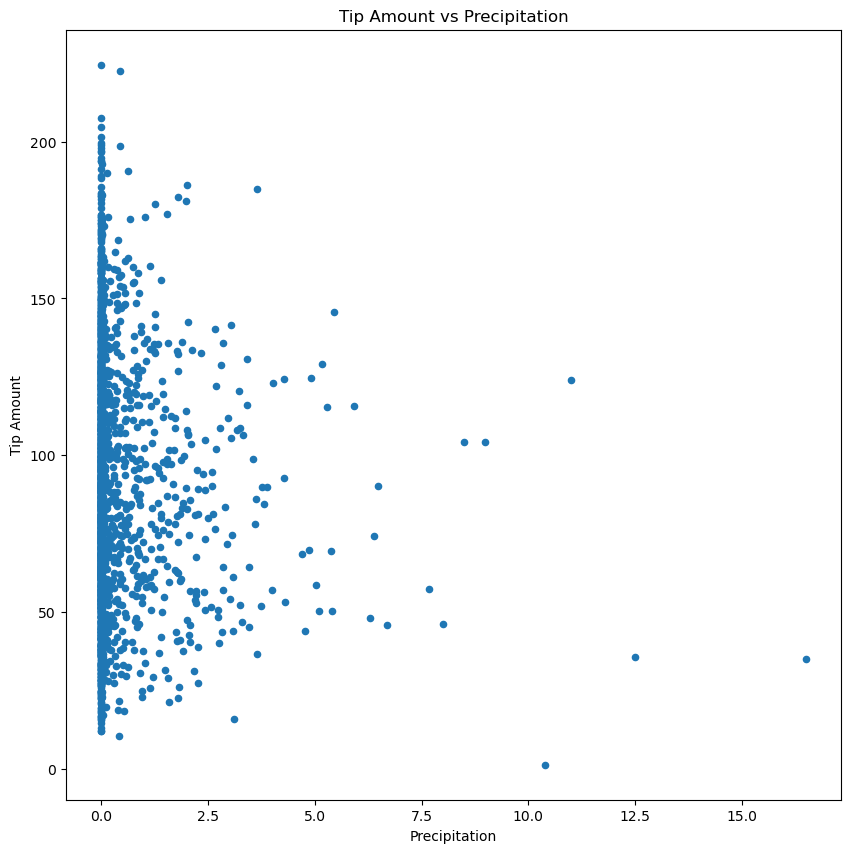

In [65]:
some_dataframe = get_data_for_visual_6()
tip_vs_precipitation(some_dataframe)

### **Visualization 6**
Create a heatmap of all hired trips over a map of the area

In [66]:
def heatmap_of_hired_trips(df):
    # The format of the diagram
    def generateBaseMap(default_location=[40.693943, -73.985880], default_zoom_start=11):
        base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
        return base_map

    base_map = generateBaseMap()
    HeatMap(data=df[['pickup_latitude', 'pickup_longitude', 'count']].\
            groupby(['pickup_latitude', 'pickup_longitude']).sum().reset_index().values.tolist(), \
            radius=8, max_zoom=13).add_to(base_map)
    
    return base_map

In [67]:
def get_data_for_visual_4():
    # select the data as dataframe
    taxi_data_copy = taxi_data.copy()
    taxi_data_copy['count'] = 1
    taxi_data_copy[['pickup_latitude', 'pickup_longitude', 'count']].groupby(['pickup_latitude', 'pickup_longitude']).sum().sort_values('count', ascending=False).head(10)
    
    return taxi_data_copy

In case any abnormal display situation occurs, we insert a screenshot of the expected output below.                    The expected output is an interactive map, which may be dysfunctional in GitHub display. To achieve full display,   you can watch this notebook at the nbviewer https://nbviewer.org/  (Please enter the GitHub location           https://github.com/leonlou3/Python/blob/main/Project.ipynb at the main page of the nbviewer)


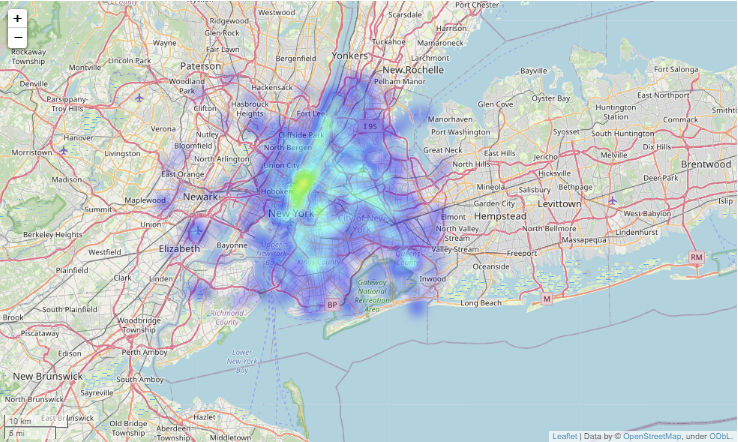

In [68]:
hired_trips_dataframe = get_data_for_visual_4()
heatmap_of_hired_trips(hired_trips_dataframe)